In [3]:
# !pip install mediapipe

In [4]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import math
from typing import List, Mapping, Optional, Tuple, Union

import dataclasses

from mediapipe.framework.formats import detection_pb2
from mediapipe.framework.formats import location_data_pb2
from mediapipe.framework.formats import landmark_pb2

In [5]:
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

from matplotlib import cm, colors, colormaps
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.patches as patches

In [6]:
# # fnames = sorted( glob.glob('./5kBabies/csvs_dir*/*.csv') )
# fnames = sorted( glob.glob('./csvs_dir*/*.csv') )

In [7]:
# fnames[:5]

In [8]:
# len(fnames)

In [5]:
# id2fnames = {}
# for fname in fnames:
#     id2fnames[ int(fname.split('/')[-1].split('-')[0]) ] = fname

In [6]:
# list(id2fnames.keys())[:5]

In [7]:
# list(id2fnames.values())[:5]

In [8]:
# df_labels = pd.read_excel('./Patrick_List of subjects.xlsx')

In [9]:
# df_labels

In [10]:
# df_labels.shape

In [11]:
# df_labels_728 = df_labels.iloc[:-2]

In [12]:
# df_labels_728.shape

In [13]:
# df_labels_728.columns = ['study_id', 'normal_aberrant',  'has_other_subject_id', 'subject_id']

In [14]:
# df_labels_728 = df_labels_728[['study_id', 'subject_id', 'has_other_subject_id', 'normal_aberrant']]

In [15]:
# df_labels_728['has_other_subject_id'] = df_labels_728['has_other_subject_id'].astype(bool)

In [16]:
# df_labels_728.head()

In [17]:
# fnames_data = []
# for _, row in df_labels_728.iterrows():
#     # if row['study_id'] != row['subject_id']:
#     #     print(row)
#     # print()
#     study_id = row['study_id']
#     if study_id in id2fnames:
#         fnames_data.append( id2fnames[ study_id ])
#     else:
#         fnames_data.append( None )

In [18]:
# len(fnames_data)

In [19]:
# df_labels_728['fname_data'] = fnames_data

In [20]:
# df_labels_726 = df_labels_728[~df_labels_728['fname_data'].isna()]

In [21]:
# df_labels_726.to_csv('./list_of_subjects_726_withFNAMES.csv', index=False)

In [22]:
df_meta = pd.read_csv('./list_of_subjects_726_withFNAMES.csv')

In [23]:
df_meta

,study_id,subject_id,has_other_subject_id,normal_aberrant,fname_data
0,592,592,True,Normal,data/csv/592-aafcb787-M-28-2010221627.csv
1,593,593,True,Normal,data/csv/593-0731adb1-F-34-2010221716.csv
2,1838,1838,True,Normal,data/csv/1838-1976fc8e-M-44-2010271018.csv
3,5388,5388,True,Aberrant,data/csv/5388-8d8a8bdc-M-165-2010271636.csv
4,8015,8015,True,Normal,data/csv/8015-d6a22f17-M-39-2010291126.csv
...,...,...,...,...,...
721,26341,NaN,True,Aberrant,data/csv/26341-3f0b11af-230510125836.csv
722,26345,NaN,True,Aberrant,data/csv/26345-3077fc95-230511111407.csv
723,26469,NaN,True,Aberrant,data/csv/26469-8ab03672-230607115705.csv
724,26585,NaN,True,Aberrant,data/csv/26585-0aeb7854-230717105743.csv


In [24]:
df_meta.shape

(726, 5)

In [ ]:
# frame_counts = []
# for fname_data in tqdm( df_meta['fname_data'] ):
#     df_data = pd.read_csv(fname_data)
#     frame_counts.append( df_data['frame'].iloc[-1] )

In [ ]:
# np.sum(frame_counts)

In [ ]:
# plt.hist( frame_counts, bins=20, )
# plt.xlabel('Number of Frames')
# plt.ylabel('Count')
# plt.savefig('./frame_stats.pdf')
# plt.show()

In [61]:
fname_data = df_meta.iloc[-1]['fname_data']

In [62]:
fname_data

'data/csv/26604-8891d2f5-230725130919.csv'

In [63]:
df_data = pd.read_csv( fname_data )

In [64]:
df_data.head(5)

,file_name,frame,landmark,x,y,z,visibility
0,26604-8891d2f5-230725130919,0,nose,0.553670,0.450553,-0.102320,0.999999
1,26604-8891d2f5-230725130919,0,left_eye_inner,0.554441,0.443597,-0.083169,0.999999
2,26604-8891d2f5-230725130919,0,left_eye,0.554895,0.445806,-0.083246,0.999998
3,26604-8891d2f5-230725130919,0,left_eye_outer,0.555389,0.448556,-0.083196,0.999998
4,26604-8891d2f5-230725130919,0,right_eye_inner,0.550759,0.438195,-0.090858,1.000000


In [65]:
len(df_data)

356499

In [136]:
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, 
    image_width: int, image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))
    
    if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
        # TODO: Draw coordinates even if it's outside of the image bounds.
        return None

    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px

In [66]:
df_data['landmark'].unique()

array(['nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
       'right_eye_inner', 'right_eye', 'right_eye_outer', 'left_ear',
       'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_pinky', 'right_pinky', 'left_index',
       'right_index', 'left_thumb', 'right_thumb', 'left_hip',
       'right_hip', 'left_knee', 'right_knee', 'left_ankle',
       'right_ankle', 'left_heel', 'right_heel', 'left_foot_index',
       'right_foot_index'], dtype=object)

In [121]:
joints2keep = ['nose', 
               'left_eye', 'right_eye', 
               # 'left_ear', 'right_ear', 
               # 'mouth_left', 'mouth_right', 
               'left_shoulder', 'right_shoulder', 
               'left_elbow', 'right_elbow', 
               'left_wrist', 'right_wrist', 
               'left_hip', 'right_hip', 
               'left_knee', 'right_knee', 
               'left_ankle', 'right_ankle', 
               # 'left_heel', 'right_heel'
]

In [122]:
len(joints2keep)

15

In [123]:
rows = []
for _, row in tqdm( df_data.iterrows() ):
    if row['landmark'] in joints2keep:
        rows.append(row)

356499it [00:03, 90500.81it/s] 


In [124]:
len(rows)

162045

In [125]:
df_data_lessJoints = pd.DataFrame(rows)

In [126]:
df_data_lessJoints

,file_name,frame,landmark,x,y,z,visibility
0,26604-8891d2f5-230725130919,0,nose,0.553670,0.450553,-0.102320,0.999999
2,26604-8891d2f5-230725130919,0,left_eye,0.554895,0.445806,-0.083246,0.999998
5,26604-8891d2f5-230725130919,0,right_eye,0.548106,0.435711,-0.090975,1.000000
11,26604-8891d2f5-230725130919,0,left_shoulder,0.543897,0.496113,0.019915,0.999963
12,26604-8891d2f5-230725130919,0,right_shoulder,0.506510,0.455413,-0.012577,0.999971
...,...,...,...,...,...,...,...
356490,26604-8891d2f5-230725130919,10802,right_hip,0.547771,0.568913,-0.055082,0.999981
356491,26604-8891d2f5-230725130919,10802,left_knee,0.584010,0.603839,0.074133,0.573400
356492,26604-8891d2f5-230725130919,10802,right_knee,0.577592,0.609348,-0.168968,0.996132
356493,26604-8891d2f5-230725130919,10802,left_ankle,0.591680,0.674116,0.119215,0.779318


In [127]:
# df_data_lessJoints.columns

In [128]:
reduce_dim = True

In [129]:
if reduce_dim:
    df_data_lessJoints_rightDim = df_data_lessJoints[['file_name', 'frame', 'landmark', 'x', 'y', 'visibility']]

In [130]:
df_data_lessJoints_rightDim

,file_name,frame,landmark,x,y,visibility
0,26604-8891d2f5-230725130919,0,nose,0.553670,0.450553,0.999999
2,26604-8891d2f5-230725130919,0,left_eye,0.554895,0.445806,0.999998
5,26604-8891d2f5-230725130919,0,right_eye,0.548106,0.435711,1.000000
11,26604-8891d2f5-230725130919,0,left_shoulder,0.543897,0.496113,0.999963
12,26604-8891d2f5-230725130919,0,right_shoulder,0.506510,0.455413,0.999971
...,...,...,...,...,...,...
356490,26604-8891d2f5-230725130919,10802,right_hip,0.547771,0.568913,0.999981
356491,26604-8891d2f5-230725130919,10802,left_knee,0.584010,0.603839,0.573400
356492,26604-8891d2f5-230725130919,10802,right_knee,0.577592,0.609348,0.996132
356493,26604-8891d2f5-230725130919,10802,left_ankle,0.591680,0.674116,0.779318


In [131]:
lm2measures = {}
for lm in df_data_lessJoints_rightDim['landmark'].unique():

# for fnum, row in df_data_lessJoints_rightDim['frame'].unique():

    df_tmp = df_data_lessJoints_rightDim[df_data_lessJoints_rightDim['landmark']==lm]

    print(lm, len(df_tmp))

    lm2measures[lm] = []
    for _, row in df_tmp.iterrows():
        lm2measures[lm].append( [ int(640 * row['x']), int(row['y' ] * 480) ] )
        
    # fnum2stats[fnum] = {
        
    #     'arr_s': arr_s ,
    #     'arr_mask': arr_mask ,
        
    #     'tblr': [ t, b, l, r ] ,
    #     'tblr_pad': [ t_pad, b_pad, l_pad, r_pad ] ,
        
    #     't_body': t_body ,

    #     'CoP_entire': [ CoP_x_entire, CoP_y_entire ] ,
    #     'CoP_entire_ani': [ [ CoP_x_entire ], [ CoP_y_entire ] ] ,

    #     'CoP_head': [ CoP_x_head, t_pad + CoP_y_head ] ,
    #     'CoP_head_ani': [ [ CoP_x_head ], [ t_pad + CoP_y_head ] ] ,
        
    #     'CoP_body': [ CoP_x_body, t_body + CoP_y_body ] ,
    #     'CoP_body_ani': [ [ CoP_x_body ], [ t_body + CoP_y_body ] ] ,

    #     'col_index': col_index
        
    # }

nose 10803
left_eye 10803
right_eye 10803
left_shoulder 10803
right_shoulder 10803
left_elbow 10803
right_elbow 10803
left_wrist 10803
right_wrist 10803
left_hip 10803
right_hip 10803
left_knee 10803
right_knee 10803
left_ankle 10803
right_ankle 10803


In [132]:
# lm2measures['nose']

In [133]:
# lm2measures['nose']

In [134]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

# plt.xlim(0,640)
# plt.ylim(0,480)

# plt.gca().invert_yaxis()

# points_lm = []
# for lm in lm2measures:
#     point_lm, = ax.plot(
#         lm2measures[lm][0][0],
#         lm2measures[lm][0][1],
#         c='red',
#         marker = '.',
#         markersize = 15
#     )

# # for i, lm in enumerate(lm2measures):
# #     # print(i)
# #     # ax.annotate(txt, (x[i], y[i]))
# #     ax.annotate(lm, (lm2measures[lm][0][0], lm2measures[lm][0][1]))


# plt.show()

/var/folders/m9/wrbj9lr10ynbn58cq8f6pmbw0000gp/T/ipykernel_52189/1263491096.py:84: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lm2point_ax[lm].set_data( [ lm2measures[lm][fnum][0], lm2measures[lm][fnum][1] ] )
/var/folders/m9/wrbj9lr10ynbn58cq8f6pmbw0000gp/T/ipykernel_52189/1263491096.py:84: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lm2point_ax[lm].set_data( [ lm2measures[lm][fnum][0], lm2measures[lm][fnum][1] ] )


Saving to ./test2.mp4...
Done.


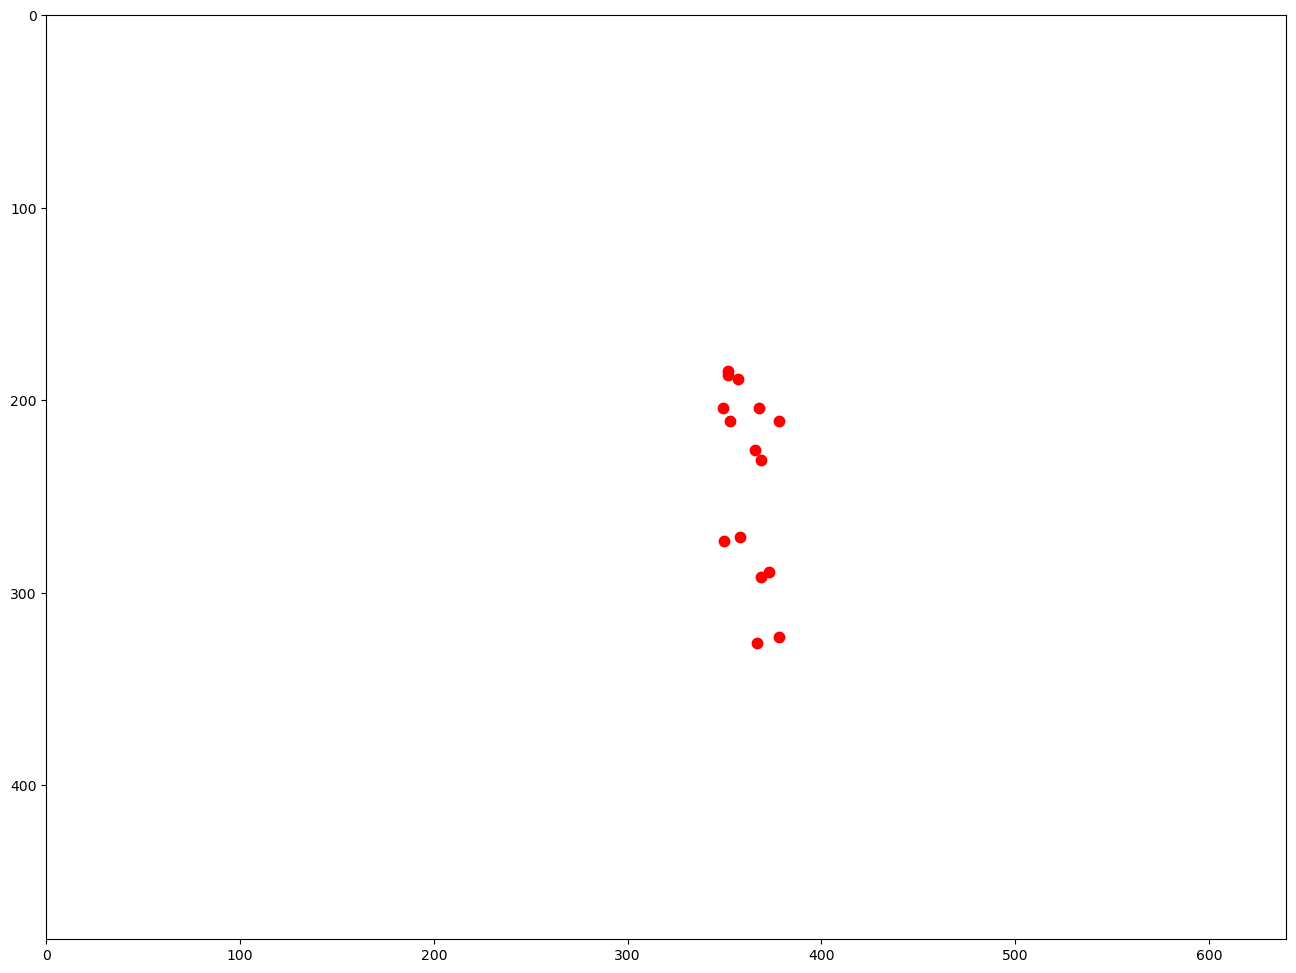

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))

plt.xlim(0,640)
plt.ylim(0,480)

plt.gca().invert_yaxis()

# plt.xticks([i for i in range(32)], [''] * 32)
# plt.yticks([i for i in range(32)], [''] * 32)
# plt.xticks([i for i in range(32)])
# plt.yticks([i for i in range(32)])
# plt.xticks([])
# plt.yticks([])

# plt.grid()
# plt.gca().invert_yaxis()

# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white') 
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines[['top','left','bottom','right']].set_color('white')

# ax.spines[['top','left','bottom','right']].set_linewidth(3)

# ax.set_facecolor(colors[fnum2stats[0]['col_index']][0])

# pressure_ax = ax.scatter(
#     x_flat,
#     y_flat,
#     s=fnum2stats[0]['arr_s'].flatten(),
#     c=colors[fnum2stats[0]['col_index']][1],
#     marker='o',
#     # alpha=0.5
# )

# CoP_body_ax, = ax.plot(
#     fnum2stats[0]['CoP_entire_ani'],
#     c=colors[fnum2stats[0]['col_index']][1],
#     marker = '.',
#     markersize = 25
# )

lm2point_ax = {}
for lm in lm2measures:
    point_ax, = ax.plot(
        lm2measures[lm][0][0],
        lm2measures[lm][0][1],
        c='red',
        marker = '.',
        markersize = 15
    )
    lm2point_ax[lm] = point_ax


# if draw_other_points:
#     t,b,l,r = fnum2stats[0]['tblr_pad']
#     t_body = fnum2stats[0]['t_body']
#     points = [[l,t_body], [l,b], [r,t_body], [r,b]]
#     CoP_body_xy = fnum2stats[0]['CoP_body']
#     points_ax, lines_ax = [], []
#     for point in points:
#         point_ax, = ax.plot( 
#             point[0], point[1], 
#             c='green',
#             marker='x',
#             markersize=25
#         )
#         points_ax.append(point_ax)

# coords_list = get_coords_for_5_quads( fnum2stats[0]['CoP_body'] )
# for coords in coords_list:
#     rect_tmp = patches.Rectangle(
#         (coords[0], coords[1]), 3, 3, 
#         linewidth=1, edgecolor='r', facecolor='none'
#     )
#     ax.add_patch(rect_tmp)

# Function to update the scatter plot
def update(fnum):

    # points_lm = []
    for lm in lm2point_ax:
        lm2point_ax[lm].set_data( [ lm2measures[lm][fnum][0], lm2measures[lm][fnum][1] ] )

        # point_lm, = ax.plot(

        #     c='red',
        #     marker = '.',
        #     markersize = 15
        # )
    
    # c_mat, c_points = colors[fnum2stats[fnum]['col_index']][:]

    # ax.set_facecolor( c_mat )
    
    # pressure_ax.set_sizes( fnum2stats[fnum]['arr_s'].flatten() )
    # pressure_ax.set_color( c_points )
    
    # CoP_body_ax.set_data( fnum2stats[fnum]['CoP_entire_ani'][:] )
    # CoP_body_ax.set_color( c_points )

    # if draw_other_points:
    
    #     t,b,l,r = fnum2stats[fnum]['tblr_pad']
    #     t_body = fnum2stats[fnum]['t_body']
    #     points_new = [[l,t_body], [l,b], [r,t_body], [r,b]]
    #     for point_new, point_ax in zip(points_new, points_ax):
    #         point_ax.set_data( [point_new[0]], [point_new[1]] )

    # CoP_body_xy = fnum2stats[fnum]['CoP_body']

    # rect.set_xy( (i2stats[i]['xywh'][0], 
    #               i2stats[i]['xywh'][1]) )
    # rect.set_width( i2stats[i]['xywh'][2] )
    # rect.set_height( i2stats[i]['xywh'][3] )

    # lr_line.set_xdata( i2stats[i]['CoP'][1] )
        
    return list(lm2point_ax.values()) # pressure_ax, # CoP_body_ax, # rect,

animation = ani.FuncAnimation(fig, update,
                              frames=[x for x in range(0,len(lm2measures['nose']))], 
                              interval=30, 
                              blit=True)

# Save the animation
fname_out = './test2.mp4'
print('Saving to {}...'.format(fname_out))
animation.save(fname_out)
print('Done.')

In [ ]:
m_side_of_body = {}
for lm in df_data['landmark'].unique():
    if 'left' in lm:
        m_side_of_body[lm] = 'left'
    elif 'right' in lm:
        m_side_of_body[lm] = 'right'
    else:
        m_side_of_body[lm] = 'center'

In [ ]:
# m_side_of_body

In [ ]:
m_body_or_face = {}
for lm in df_data[df_data['frame']==0]['landmark'].values[:11]:
    m_body_or_face[lm] = 'face'
for lm in df_data[df_data['frame']==0]['landmark'].values[11:]:
    m_body_or_face[lm] = 'body'

In [ ]:
# m_body_or_face

In [ ]:
m_above_the_hip = {}
for lm in df_data[df_data['frame']==0]['landmark'].values[:23]:
    m_above_the_hip[lm] = True
for lm in df_data[df_data['frame']==0]['landmark'].values[23:]:
    m_above_the_hip[lm] = False

In [ ]:
# m_above_the_hip

In [ ]:
main_joints = [
    'nose', 
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist',
    'left_hip', 'right_hip',
    'left_knee', 'right_knee',
    'left_ankle', 'right_ankle'
]

In [ ]:
m_main_joint_or_not = { lm: lm in main_joints for lm in df_data['landmark'].unique() }

In [ ]:
# m_main_joint_or_not

In [ ]:
df_data['side_of_body']  = [ m_side_of_body[lm] for lm in df_data['landmark'] ]

In [ ]:
df_data['body_or_face']  = [ m_body_or_face[lm] for lm in df_data['landmark'] ]

In [ ]:
df_data['above_the_hip'] = [ m_above_the_hip[lm] for lm in df_data['landmark'] ]

In [ ]:
df_data['main_joint']    = [ m_main_joint_or_not[lm] for lm in df_data['landmark'] ]

In [ ]:
df_data.head()

In [ ]:
## FROM DRAWING_UTILS.PY

In [ ]:
# lm2distances = {}
# for lm in tqdm( df_data['landmark'].unique() ):
    
#     # print(lm)
    
#     df_data_tmp = df_data[df_data['landmark']==lm].reset_index()
    
#     distances = []
#     for i, row in df_data_tmp.iloc[1:].iterrows():
#         xyz_prev = np.asarray( df_data.iloc[i-1][['x','y','z']].values )
#         xyz_curr = np.asarray( row[['x','y','z']].values )
#         # print(i, (i-1*33))
#         # # print(row)
#         # print( xyz_prev, xyz_curr ) 
#         distances.append(  np.linalg.norm(xyz_prev - xyz_curr) )
    
#     lm2distances[lm] = distances

In [ ]:
lm2distances_stats = {}
for lm, distances in lm2distances.items():
    s = pd.Series(distances)
    # print( lm, s.mean(), s.std() )
    lm2distances_stats[lm] = [s.mean(), s.std()]

In [ ]:
# lm

In [ ]:
lm2distances_stats['nose']

In [ ]:
df_lm2distances_stats = pd.DataFrame.from_dict(lm2distances_stats).T

In [ ]:
df_lm2distances_stats.columns = ['mean','std']

In [ ]:
# df_lm2distances_stats.sort_values(by='mean', ascending=False).head()
# df_lm2distances_stats.sort_values(by='mean', ascending=True).head()

In [ ]:
# df_lm2distances_stats.sort_values(by='std', ascending=False).head()
# df_lm2distances_stats.sort_values(by='std', ascending=True).head()

In [ ]:
# plt.figure(figsize=(12,8), facecolor='white')
# plt.plot( lm2distances['nose'], alpha=0.75 )
# # plt.plot( lm2distances['left_shoulder'], alpha=0.75 )
# # plt.plot( lm2distances['right_hip'], alpha=0.75 )
# plt.show()

In [ ]:
frame_rate = 30
num_seconds = 30